# Rock geospatial analysis

## Install dependencies

In [ ]:
! pip install geopandas pysal networkx

## Download the rock dataset (GeoJSON file)

You can also use shape files. Upload the shape file on file browser in colab.

In [ ]:
import geopandas

# Read a GeoJSON file
url = "https://rocks.deepgis.org/static/scripts/data.json"
df = geopandas.read_file(url)

In [ ]:
df.head()

options                                           geometry
0  {'color': 'rgb(255, 0, 0)', 'weight': 0.5}  POLYGON ((-118.44275 37.45471, -118.44275 37.4...
1  {'color': 'rgb(255, 0, 0)', 'weight': 0.5}  POLYGON ((-118.44276 37.45470, -118.44277 37.4...
2  {'color': 'rgb(255, 0, 0)', 'weight': 0.5}  POLYGON ((-118.44101 37.45063, -118.44101 37.4...
3  {'color': 'rgb(255, 0, 0)', 'weight': 0.5}  POLYGON ((-118.44313 37.45139, -118.44313 37.4...
4  {'color': 'rgb(255, 0, 0)', 'weight': 0.5}  POLYGON ((-118.44136 37.45328, -118.44136 37.4...

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 30)


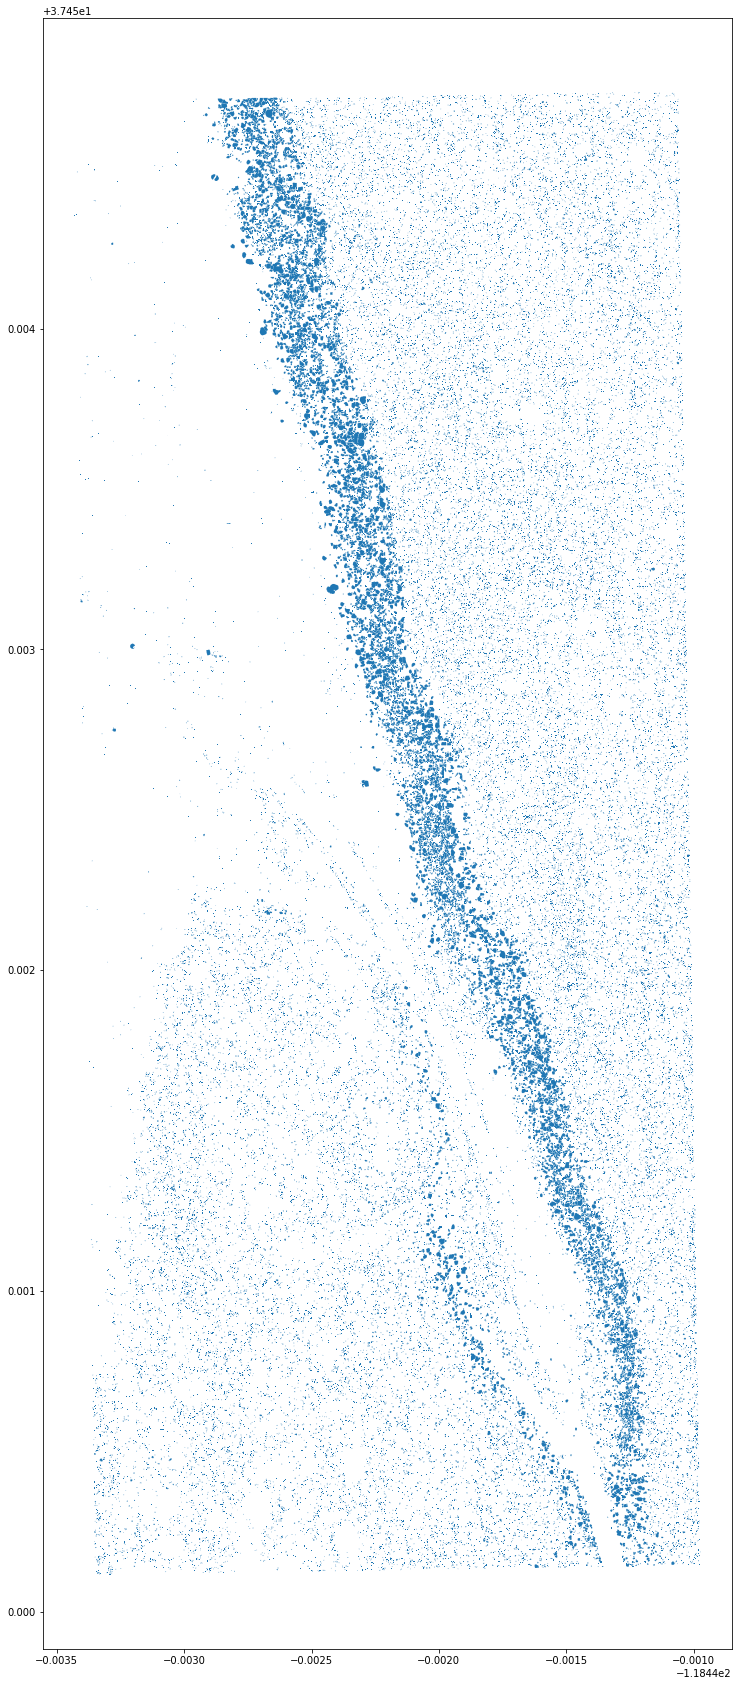

In [ ]:
fig, ax = plt.subplots(1, 1)

df.plot(ax=ax)

## Plot area of rocks

In [ ]:
df = df.to_crs({'init': 'epsg:3857'})
df['area'] = df['geometry'].area

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


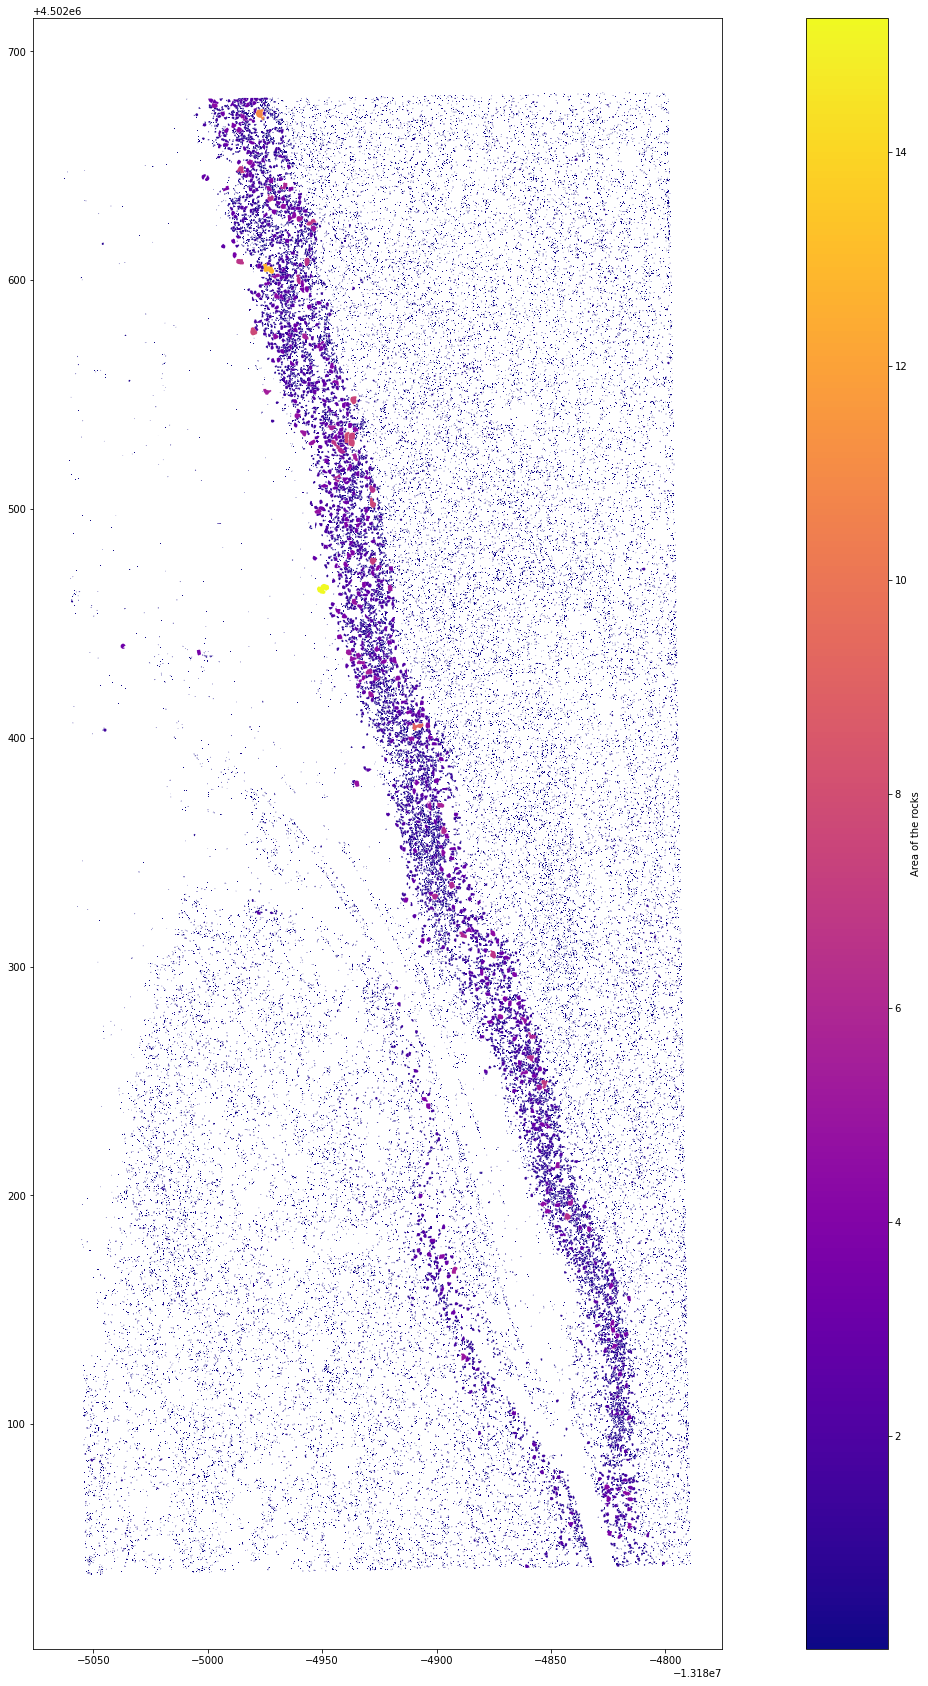

In [ ]:
fig, ax = plt.subplots(1, 1)
df.sort_values('area').plot(column='area',
        ax=ax,
        legend=True,
        legend_kwds={'label': "Area of the rocks",
                    'orientation': "vertical"},
        cmap='plasma')

## Show centroids as Points

In [ ]:
df['centroid'] = df['geometry'].centroid

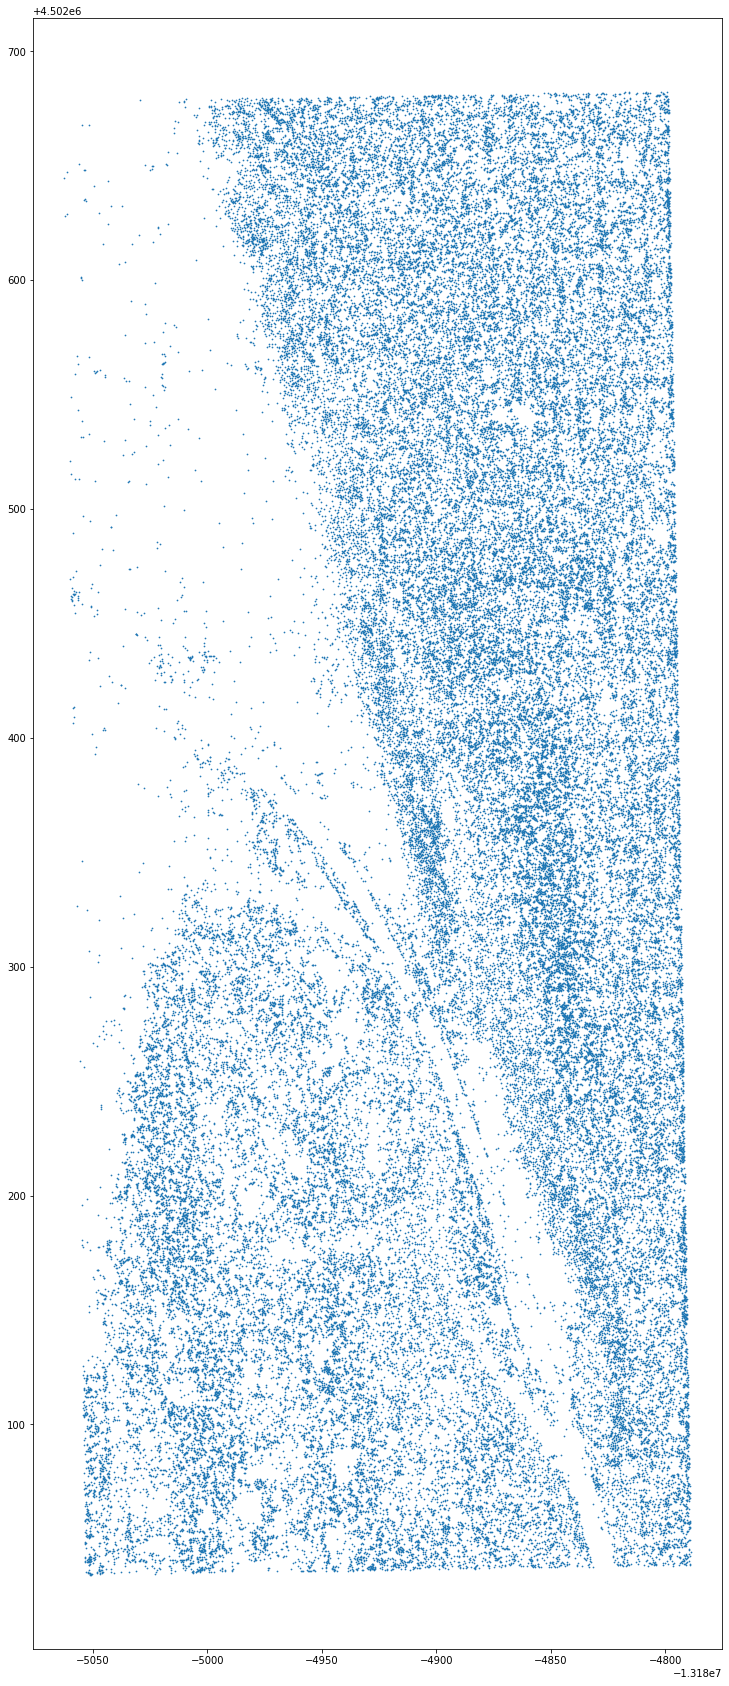

In [ ]:
fig, ax = plt.subplots(1, 1)

df['centroid'].plot(ax=ax, marker='o', markersize=0.5)

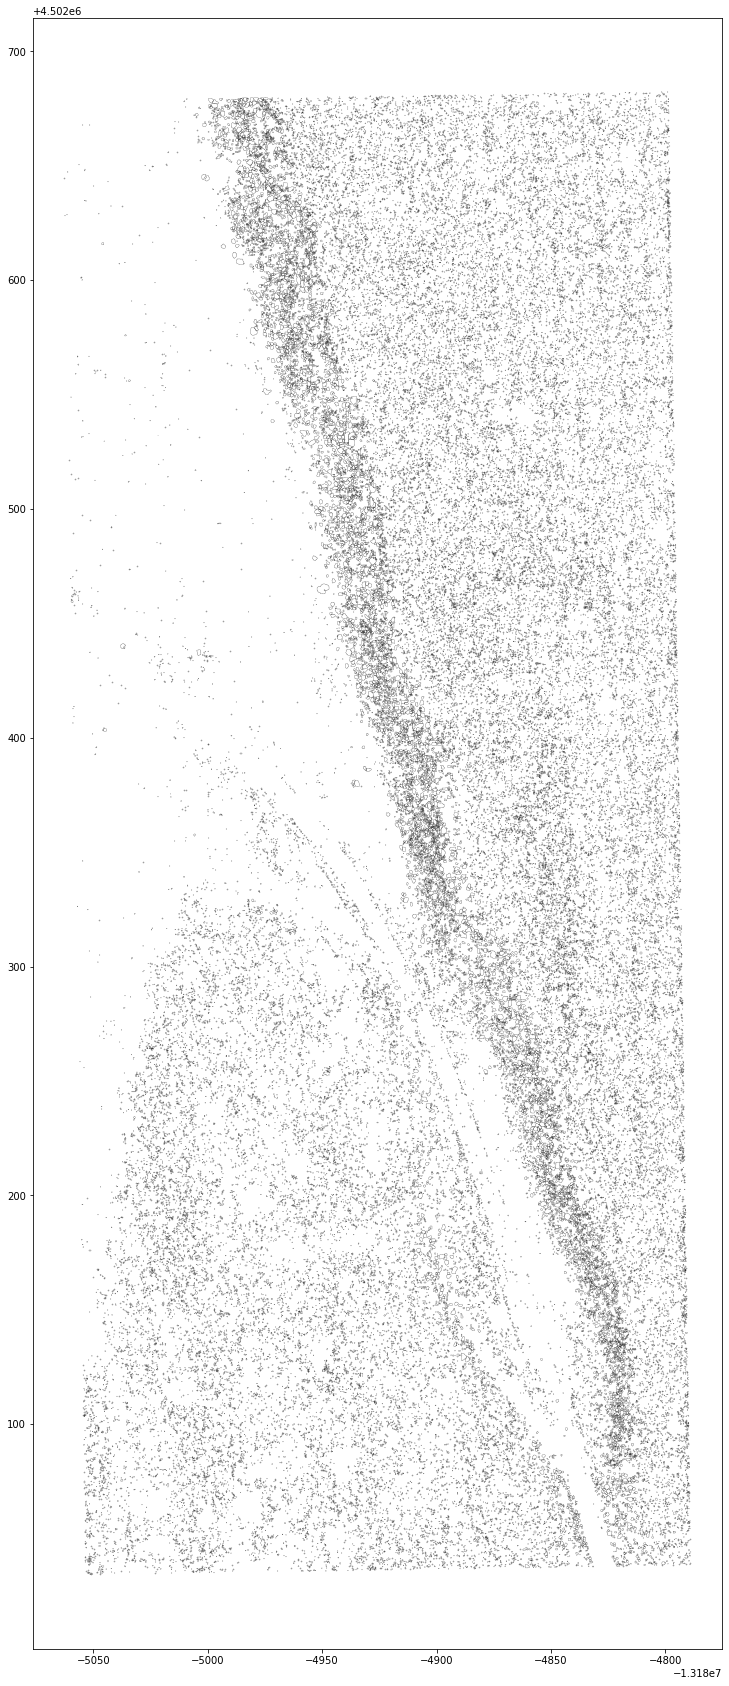

In [ ]:
# Plot polygons without color filling
fig, ax = plt.subplots(1, 1)
df.plot(ax=ax, 
        facecolor='none', 
        edgecolor='k', 
        linewidth=.02
      )

## Remove NaN values in the data

In [ ]:
drop_rows = np.where(np.isnan(df["area"]))
drop_rows

(array([31106, 76355, 79781]),)

In [ ]:
df = df.drop(drop_rows[0])

## Find rock polygons that interesect with other polygons (testing with 100 points that are huge)

***Rook*** contiguity requires that the pair of polygons in question share an edge. (Polygons that touch each other)

Rook contiguity for P0 is P1 and P3. For P1 is P0, P4, P2.
```
P0 | P1 | P2
------------
P3 | P4 | P5
------------
```

In [ ]:
import libpysal as lp
import numpy as np

In [ ]:
df_big = df.sort_values('area', ascending=False)
df_big = df_big.iloc[:, :]
df_big = df_big.reset_index(drop=True)

In [ ]:
Rneighbs = lp.weights.Rook.from_dataframe(df_big)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 67107 disconnected components.
 There are 58690 islands with ids: 0, 13, 25, 35, 36, 37, 39, 83, 88, 117, 118, 131, 135, 141, 147, 153, 161, 181, 191, 196, 199, 207, 208, 211, 220, 221, 223, 226, 244, 252, 254, 258, 272, 274, 276, 282, 283, 292, 293, 294, 307, 312, 313, 317, 324, 331, 338, 339, 352, 355, 356, 365, 366, 384, 401, 405, 416, 419, 436, 440, 442, 448, 453, 456, 461, 478, 479, 481, 484, 486, 487, 488, 490, 500, 503, 506, 508, 510, 512, 533, 534, 546, 553, 554, 560, 567, 574, 591, 595, 608, 612, 632, 637, 638, 644, 648, 649, 652, 676, 677, 697, 698, 704, 720, 725, 728, 733, 739, 744, 746, 752, 758, 759, 771, 773, 777, 779, 781, 786, 787, 799, 808, 810, 817, 818, 825, 828, 841, 860, 861, 867, 872, 877, 879, 882, 894, 898, 899, 902, 908, 911, 912, 913, 916, 919, 923, 924, 930, 933, 937, 943, 945, 948, 949, 952, 953, 954, 973, 975, 989, 991,

(<Figure size 2160x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd4f6eb790>)

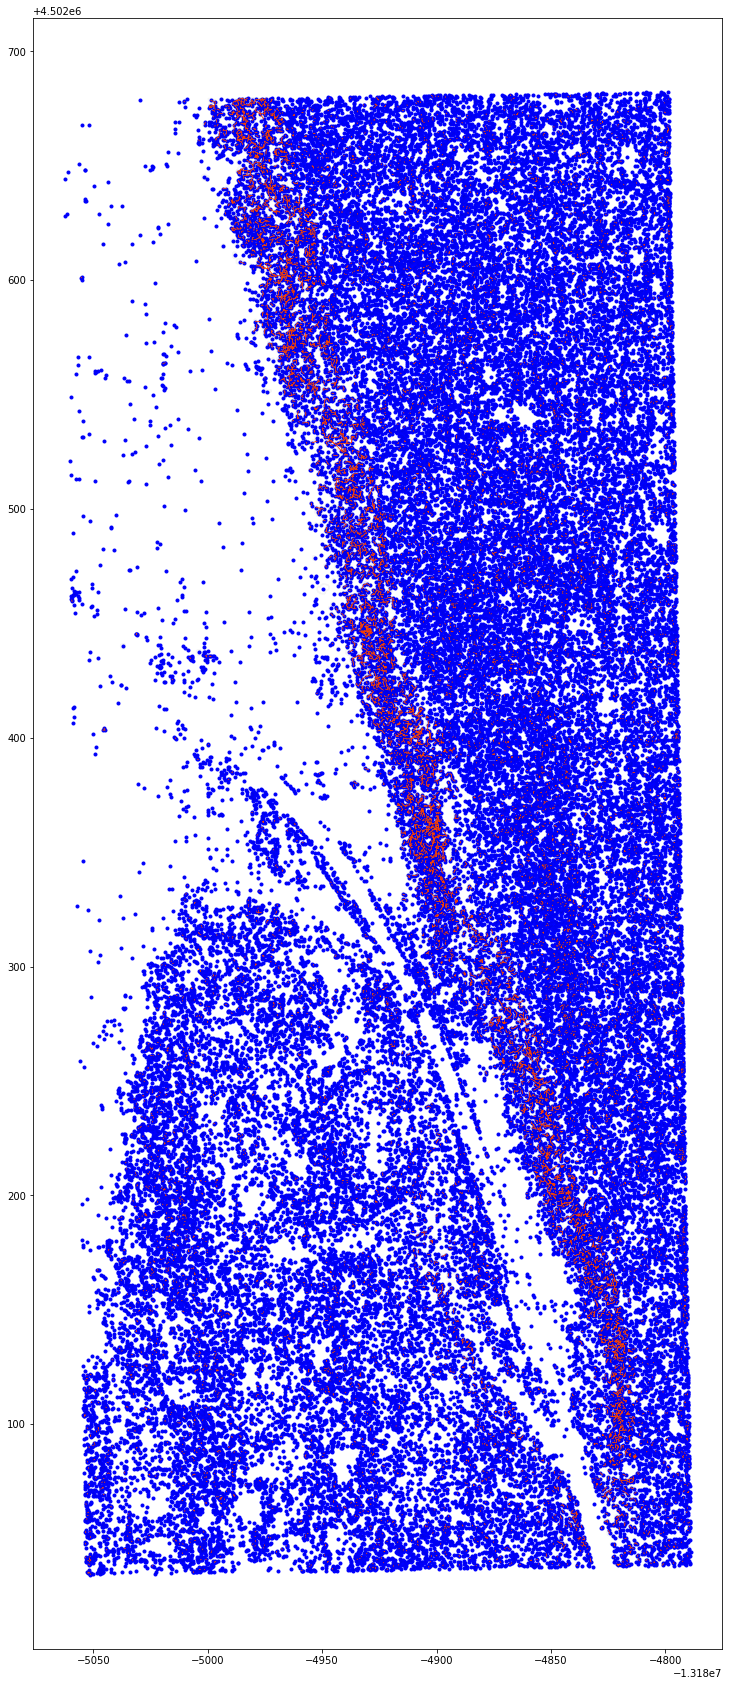

In [ ]:
fig, ax = plt.subplots(1, 1)

# 10 mins run time if you run for 80k rocks
df.boundary.plot(color='k', ax=ax, alpha=.04)
Rneighbs.plot(df_big, edge_kws=dict(linewidth=0.5, color='orangered'), node_kws=dict(marker='.', color='blue'), ax=ax)

## Gaussian distance function (need to check how the code works)

In [ ]:
Wkernel = lp.weights.Kernel.from_dataframe(df_big.iloc[:100, :])
Wkernel_adaptive_gaussian = lp.weights.Kernel.from_dataframe(df_big.iloc[:100, :], k=10, fixed=False, function='gaussian')

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [ ]:
# Wkernel.neighbors

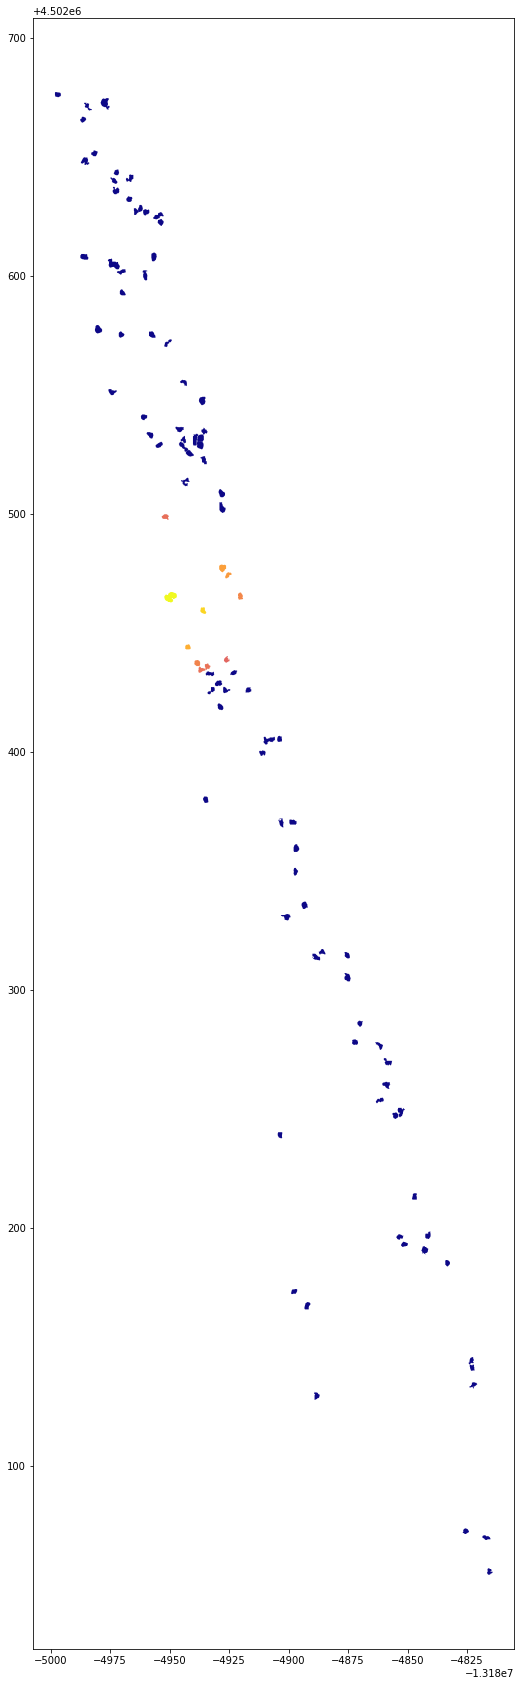

In [ ]:
df_big.iloc[:100, :].assign(weights=Wkernel_adaptive_gaussian.sparse[0,:].toarray().flatten()).plot('weights', cmap='plasma')

References



1.   https://pysal.org/spaghetti/notebooks/caveats.html
2.   https://geographicdata.science/book/notebooks/04_spatial_weights.html
3.   

